# 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    StandardScaler,
)

from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
)

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
)

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_squared_log_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    log_loss,
    auc,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    classification_report,
)

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

RAND = 10

Files
train.csv

- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

In [2]:
train_df = pd.read_csv("train.csv")

# 2. EDA

In [3]:
train_df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [4]:
train_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   county              2018352 non-null  int64  
 1   is_business         2018352 non-null  int64  
 2   product_type        2018352 non-null  int64  
 3   target              2017824 non-null  float64
 4   is_consumption      2018352 non-null  int64  
 5   datetime            2018352 non-null  object 
 6   data_block_id       2018352 non-null  int64  
 7   row_id              2018352 non-null  int64  
 8   prediction_unit_id  2018352 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [5]:
train_df = train_df.astype({
    "county": "uint8",
    "is_business": "bool",
    "product_type": "uint8",
    "is_consumption": "bool",
    "datetime": "datetime64[ns]",})

In [6]:
train_df.describe()

,county,product_type,target,datetime,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.017824e+06,2018352,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,1.898927e+00,2.748556e+02,2022-07-20 08:29:25.326166016,3.218746e+02,1.009176e+06,3.304538e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2021-09-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,3.780000e-01,2022-02-14 04:00:00,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,2.000000e+00,3.113300e+01,2022-07-21 09:30:00,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,3.000000e+00,1.802062e+02,2022-12-24 14:00:00,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,3.000000e+00,1.548027e+04,2023-05-31 23:00:00,6.370000e+02,2.018351e+06,6.800000e+01
std,4.780990e+00,1.081766e+00,9.095024e+02,NaN,1.826343e+02,5.826482e+05,1.959059e+01


In [7]:
# train_df.describe(include = "object")

In [8]:
train_df = train_df.astype(
    {
        "county": "uint8",
        "is_business": "bool",
        "product_type": "uint8",
        "is_consumption": "bool",
        "datetime": "datetime64[ns]",
    }
)

In [9]:
# df = train_df.copy().set_index("datetime")
train_df["hour"] = train_df["datetime"].dt.hour.astype("uint8")
train_df["day_of_week"] = train_df["datetime"].dt.day_of_week.astype("uint8")
train_df["day"] = train_df["datetime"].dt.day.astype("uint16")
train_df["week_of_year"] = (
    train_df["datetime"].dt.isocalendar().week.astype("int8")
)
train_df["month"] = train_df["datetime"].dt.month.astype("int8")
train_df["quarter"] = train_df["datetime"].dt.quarter.astype("int8")
train_df["year"] = train_df["datetime"].dt.year.astype("uint16")

train_df["target_modified"] = np.where(
    train_df["is_consumption"] == True,
    train_df["target"] * (-1),
    train_df["target"],
)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              uint8         
 1   is_business         bool          
 2   product_type        uint8         
 3   target              float64       
 4   is_consumption      bool          
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
 9   hour                uint8         
 10  day_of_week         uint8         
 11  day                 uint16        
 12  week_of_year        int8          
 13  month               int8          
 14  quarter             int8          
 15  year                uint16        
 16  target_modified     float64       
dtypes: bool(2), datetime64[ns](1), float64(2), int64(3), int8(3), uint16(2), uint8(4)
memory usage: 117.4 MB


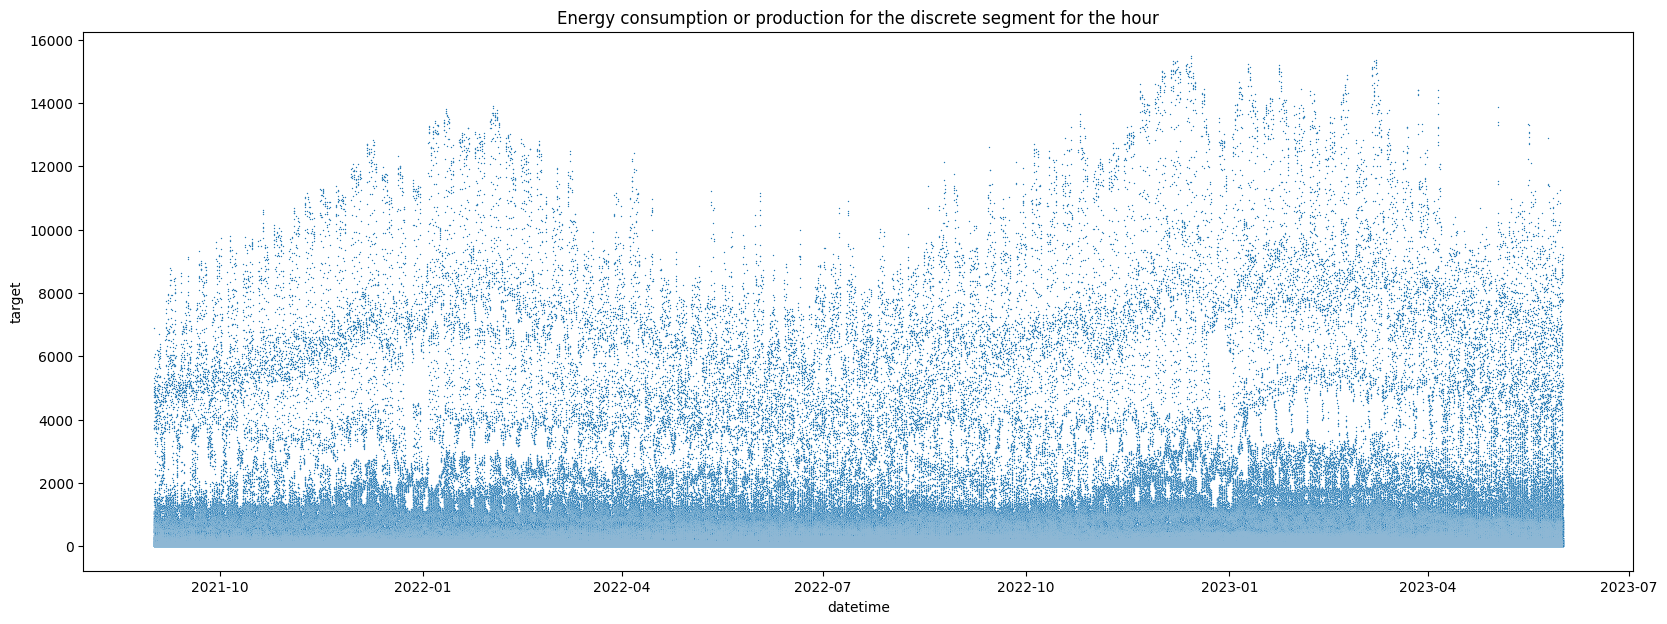

In [10]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.scatterplot(
    data=train_df,
    x="datetime",
    y="target",
    s=1,
    # hue="county",
    # style='is_business',
)
plt.title(
    "Energy consumption or production for the discrete segment for the hour"
)
plt.show()

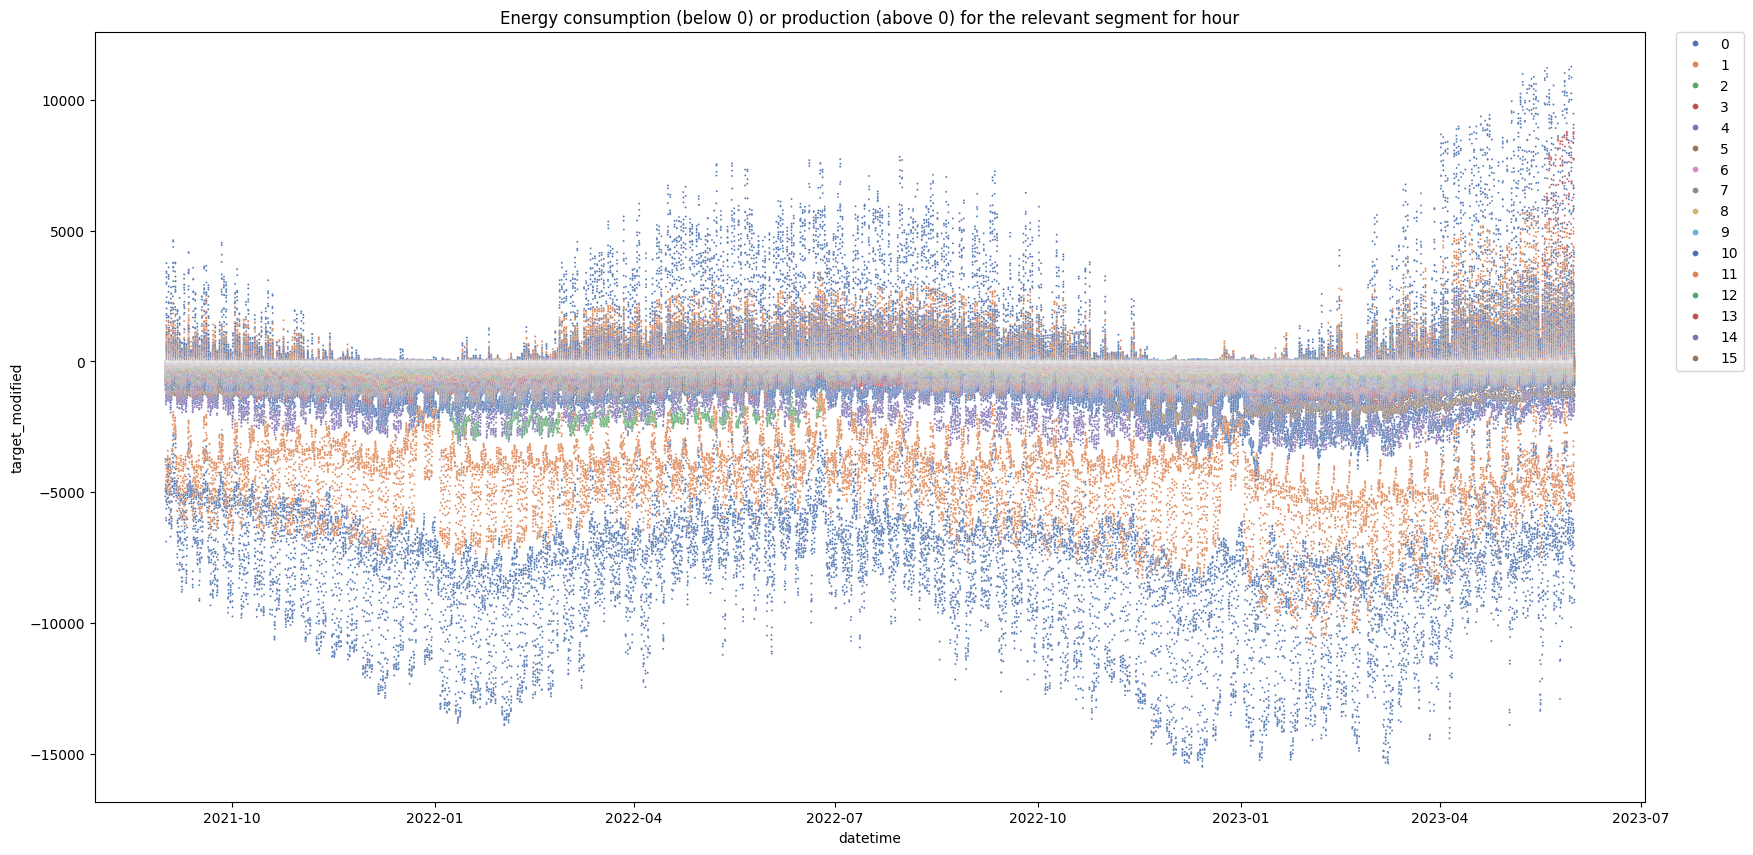

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(
    data=train_df,
    x="datetime",
    y="target_modified",
    hue="county",
    palette="deep",
    s=2,
    # style='is_business',
)

plt.title(
    "Energy consumption (below 0) or production (above 0) for the relevant segment for hour"
)
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=3,
)
# plt.yscale('symlog')
plt.show()

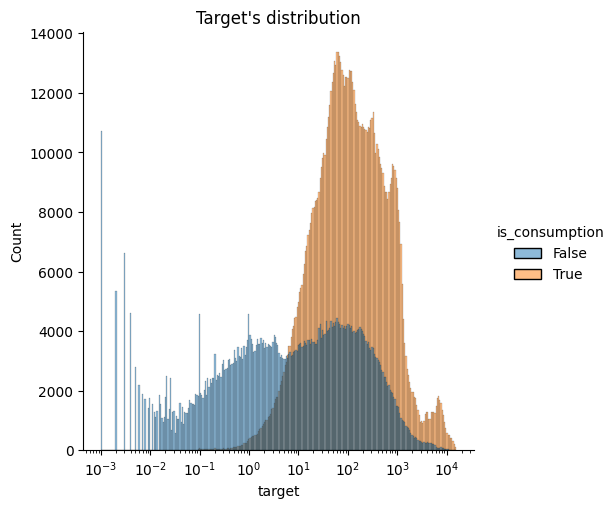

In [12]:
sns.displot(
    data=train_df,
    x="target",
    hue="is_consumption",
    log_scale=True,
)

plt.title("Target's distribution")
plt.show()

In [13]:
# target_per_county = (
#     train_df.groupby(["is_consumption", "county"])[["target"]]
#     .sum()
#     .groupby(level=0)
#     .apply(lambda x: x * 100 / x.sum())
#     .reset_index(level=0, drop=True)
#     .reset_index()
#     .rename(columns={"target": "percentage"})
# )
# target_per_county

In [14]:
# plt.figure(figsize=(18,6))

# barplot = sns.barplot(
#     data=target_per_county,
#     x="county",
#     y="percentage",
#     hue="is_consumption",
# )

# for container in barplot.containers:
#     barplot.bar_label(
#         container,
#         fmt="%.2f",
#         fontsize=9,
#     )

# plt.show()

In [15]:
def target_percentage_in_subgroup(
    df: pd.DataFrame, feature: str, broken_down_by: str, target: str
) -> pd.DataFrame:
    df = (
        df.groupby([broken_down_by, feature])[[target]]
        .sum()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .reset_index(level=0, drop=True)
        .reset_index()
        .rename(columns={"target": "percentage"})
    )
    return df

In [16]:
def plot_for_categorical_feature(
    df: pd.DataFrame,
    broken_down_by: str,
    features_list: list[str],
    target: str,
):
    length = len(features_list)
    fig, axs = plt.subplots(
        nrows=length,
        ncols=1,
        figsize=(18, 15),
    )
    fig.tight_layout(pad=5)

    for idx, feature in enumerate(features_list):
        plt.subplot(length, 1, 1 + idx)
        data = target_percentage_in_subgroup(
            df, feature, broken_down_by, target
        )

        barplot = sns.barplot(
            data=data,
            x=feature,
            y="percentage",
            hue=broken_down_by,
        )

        for container in barplot.containers:
            barplot.bar_label(
                container,
                fmt="%.2f",
            )

        plt.title(f"{feature} broken down by {broken_down_by}")
    plt.show()

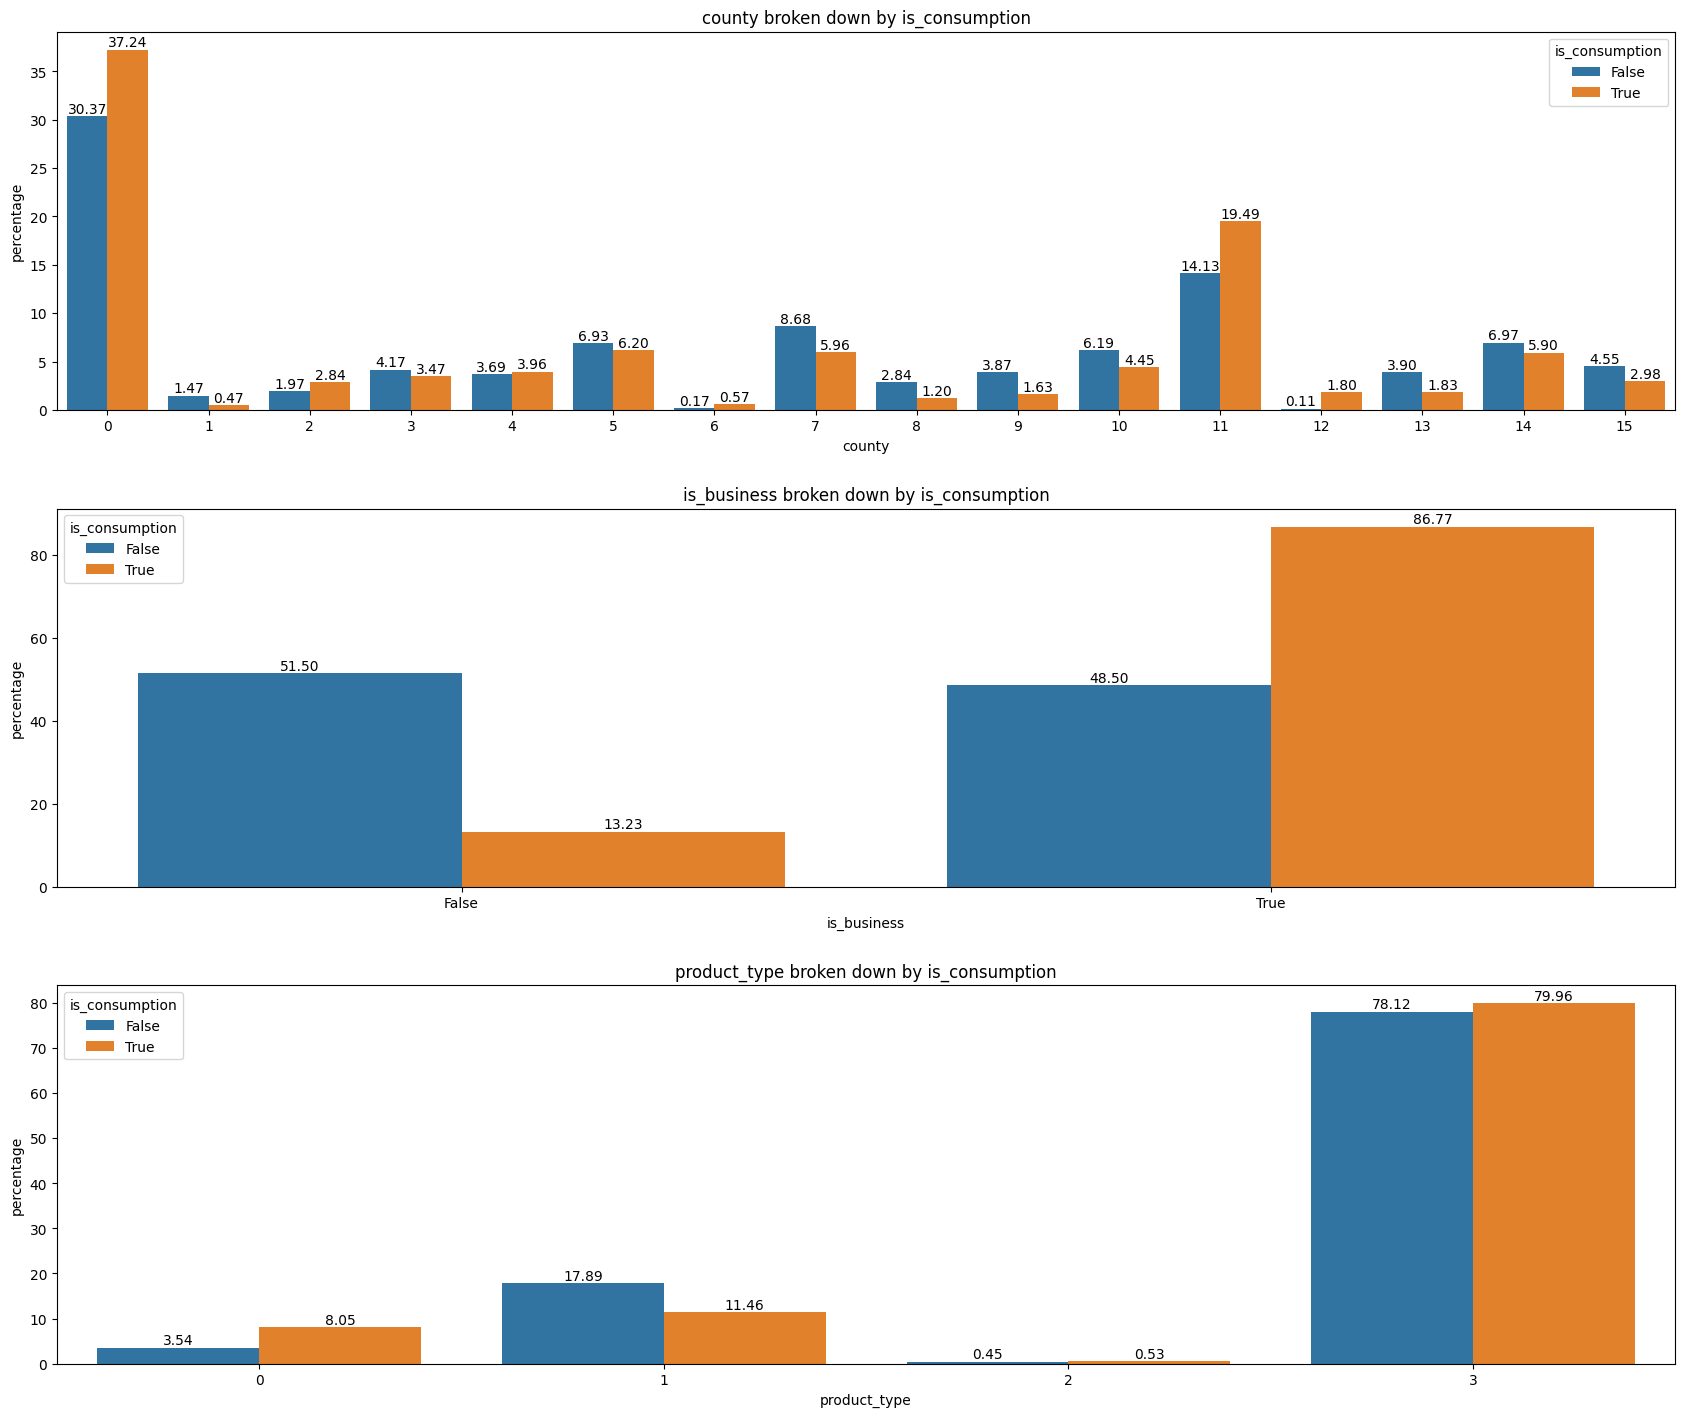

In [17]:
plot_for_categorical_feature(
    train_df,
    "is_consumption",
    ["county", "is_business", "product_type"],
    "target",
)

In [18]:
# sns.relplot(
#     data=train_df.loc[train_df['county'] == 2][["datetime", "target", "is_consumption",'is_business']],
#     x="datetime",
#     y="target",
#     col="is_consumption",
#     height=5,
#     aspect=1.5,
#     hue="is_business",
#     # size="size",
#     # style="sex",
#     # palette=["b", "r"],
#     # sizes=(10, 100),
# )

In [19]:
# fig, ax = plt.subplots(figsize=(10, 2))
# length = 24

# sns.lineplot(
#     data=[np.sin((2 * i * np.pi / (length))) for i in range(length)],
# )
# sns.lineplot(
#     data=[np.cos(i / (length / 2 / np.pi)) for i in range(length)],
# )
# # sns.lineplot(
# #     data=[np.sin((i * np.pi / 7)) for i in range(length)],
# # )
# # sns.lineplot(
# #     data=[np.tan((i / (len / np.pi)) + np.pi/2 + np.pi/len) for i in range(len)],
# # )

# # plt.xticks(range(-1, 25))
# # plt.yscale('symlog')
# plt.grid()
# plt.show()

In [20]:
# length = 24
# for idx, i in enumerate(zip([round(np.sin((2 * i * np.pi / (length))), 3) for i in range(length)], [round(np.cos((2 * i * np.pi / (length))), 3) for i in range(length)])):
#     print(idx, i)

In [21]:
# length = 365
# [np.tan((i / (length / np.pi)) + np.pi/2) for i in range(length)]

In [22]:
# list_of_sins = [np.sin(i / (len / 2 / np.pi)) for i in range(len)]
# list_of_cos = [np.cos(i / (len / 2 / np.pi)) for i in range(len)]
# list_of_tans = [(np.sin(i / (len / 2 / np.pi)))/(np.cos(i / (len / 2 / np.pi)))for i in range(len)]
# for i in zip(list_of_sins, list_of_cos, list_of_tans):
#     print(i)

In [23]:
asd

NameError: name 'asd' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# len = 10
sns.lineplot(
    data=hours_list,
    # x="datetime",
    # y="target",
    # s=1,
    # hue="county",
    # style='is_business',
)
# ax.set(title = 'Energy consumption or production for the discrete segment for the hour')
plt.grid()
plt.show()

In [ ]:
# df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))
# df['hr_cos'] = np.cos(df.hr*(2.*np.pi/24))
# df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
# df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))

In [ ]:
фывфы

In [ ]:
train_df.groupby("is_consumption")["target"].min()

In [ ]:
train_df.isna().sum()[train_df.isna().sum() != 0]

In [ ]:
train_df.duplicated().sum()[train_df.duplicated().sum() != 0]

In [ ]:
train_df.loc[train_df.isna().any(axis=1)]

In [ ]:
(
    train_df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    )
    .sort_values(
        by=[
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "datetime",
        ]
    )
    .head(21)
)

In [ ]:
[train_df[train_df.isna().any(axis=1)].datetime.unique()]

In [ ]:
train_df = train_df.sort_values(
    by=["county", "is_business", "product_type", "is_consumption", "datetime"]
).interpolate()

In [ ]:
(
    train_df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    ).head(21)
)

In [ ]:
sns.displot(
    data=train_df[["target"]],
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=train_df[["target", "is_business", "product_type"]],
    x="target",
    # bins=200,
    element="poly",
    hue="is_business",
    col="product_type",
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(train_df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.show()

In [ ]:
sns.relplot(
    data=train_df.query("county == 0 and is_business == False"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.relplot(
    data=train_df.query("county == 0 and is_business == True"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.scatterplot(
    data=train_df.query("county==0 and is_business == True"),
    x="datetime",
    y="target",
    hue="is_consumption",
)

In [ ]:
sns.scatterplot(
    data=train_df.query("is_business == True and is_consumption == False"),
    x="datetime",
    y="target",
    hue="county",
)

# 3. Feature Engineering

In [ ]:
df = train_df.copy().set_index("datetime")
df

In [ ]:
df["hour"] = df.index.hour.astype("uint8")
df["day_of_week"] = df.index.day_of_week.astype("uint8")
df["day"] = df.index.day.astype("uint16")
df["week_of_year"] = df.index.isocalendar().week.astype("int8")
df["month"] = df.index.month.astype("int8")
df["quarter"] = df.index.quarter.astype("int8")
df["year"] = df.index.year.astype("uint16")

df["target_modified"] = np.where(
    df["is_consumption"] == True, df["target"] * (-1), df["target"]
)

df.info()

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target_modified",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=df[["target_modified"]],
    x="target_modified",
    log_scale=True,
)

In [ ]:
sns.relplot(
    data=df.query("county == 0")[
        ["target_modified", "product_type", "is_consumption", "is_business"]
    ],
    x="datetime",
    y="target_modified",
    col="product_type",
    hue="is_business",
    # size="size",
    # style="sex",
    # palette=["b", "r"],
    # sizes=(10, 100),
)
# plt.axhline(y = 10,
#             color = 'r',
#             linestyle = '-',
#            lw=100,)
# plt.xscale('log')
plt.yscale("log")
plt.show()

In [ ]:
df.columns

In [ ]:
sns.scatterplot(
    data=df.query("county == 4 and product_type == 1 and is_business == 1")[
        [
            "target_modified",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="target_modified",
)
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
# # plt.figure(figsize=(25, 25))
# plt.show()
# # numeric_only=True

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.scatterplot(
    data=df.query(
        "'2023-01-1 8:00:00' <= datetime <= '2023-01-28 23:00:00' and \
        product_type == 3"
    )[
        [
            "county",
            "target_modified",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="target_modified",
    # col = 'product_type',
    # product_type
    style="is_business",
    hue="is_business",
    # aspect = 3,
    # # height = 5,
    alpha=0.5,
)
plt.show()

# county
# is_business
# product_type
# is_consumption

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df_hours[f"tm_{h}h"] = df_hours["target_modified"].shift(h)
df_hours.info()

In [ ]:
for h in i in range(24):
    df[f"tm_{i}h"] = df["target_modified"].shift(i)
df["tm_1h"] = df["target_modified"].shift(1)

In [ ]:
df.shift(periods=1)

In [ ]:
# def add_lags(df):
#     target_map = df['PJME_MW'].to_dict()
#     df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
#     df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
#     df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
#     return df

In [ ]:
df_label = df.astype(
    {
        "county": "category",
        "is_business": "category",
        "product_type": "category",
        "is_consumption": "category",
    }
)
df_label.info()

In [ ]:
df_label = pd.get_dummies(df_label, drop_first=True)
df_label.info()

In [ ]:
df_label.columns

In [ ]:
X = df_label.drop(
    columns=[
        "target",
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "target_modified",
    ],
    axis=1,
)

y = df_label["target_modified"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND
)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

In [ ]:
def r2_adjusted(
    y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray | int
) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)

    if isinstance(X_test, np.ndarray):
        N_features = X_test.shape[1]
    else:
        N_features = X_test

    #     N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true, axis=0) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true), axis=0) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def huber_loss(
    y_true: np.ndarray | pd.DataFrame,
    y_pred: np.ndarray | pd.DataFrame,
    delta: float = 1.345,
):
    """Функция ошибки Хьюбера"""

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.squeeze().to_numpy()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.squeeze().to_numpy()

    assert len(y_true) == len(y_pred), "Разные размеры данных"
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i]) ** 2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
    """функция ошибки Лог-Кош"""
    return np.sum(np.log(np.cosh(y_true - y_pred)))


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    Root Mean Squared Log Error (RMSLE) metric
    Логарифмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    X_test: np.ndarray,
    name: str = None,
    delta: float = 1.345,
):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()
    df_metrics["model"] = [name]

    df_metrics["MAE"] = mean_absolute_error(y_test, y_pred)
    df_metrics["MSE"] = mean_squared_error(y_test, y_pred)
    df_metrics["Huber_loss"] = huber_loss(y_test, y_pred, delta)
    df_metrics["Logcosh"] = logcosh(y_test, y_pred)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics["RMSLE"] = rmsle(y_test, y_pred)
    df_metrics["R2 adjusted"] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics["MPE_%"] = mpe(y_test, y_pred)
    df_metrics["MAPE_%"] = mape(y_test, y_pred)
    df_metrics["WAPE_%"] = wape(y_test, y_pred)

    return df_metrics

In [ ]:
lr_skl = LinearRegression()
lr_skl.fit(X_train_std, y_train)

In [ ]:
lr_skl_pred = lr_skl.predict(X_test_std)

In [ ]:
skl_m = get_metrics(y_test, lr_skl_pred, X_test_std, name="skl_lr")
skl_m

In [ ]:
df_hours = df_hours[
    [
        "county",
        "is_business",
        "product_type",
        "target",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "target_modified",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
]

In [ ]:
df_hours = df_hours.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_hours):
    train = df_hours.iloc[train_idx]
    test = df_hours.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
    # TARGET = "target_modified"
    TARGET = "target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df[f"t_{h}h"] = df["target"].shift(h)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 30))

sns.heatmap(df_hours.corr(), annot=True, cmap="Blues", fmt=".1f")
# plt.figure(figsize=(25, 25))
plt.show()
# numeric_only=True

In [ ]:
# df = df.sort_index().sort_values(
#     ["county", "is_business", "product_type", "is_consumption"],
#     kind="mergesort",
# )
df.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
# for train_idx, val_idx in tss.split(df):
# print('1 train:', train_idx)
# display(df.iloc[train_idx].tail(5))
# print('1 val:', val_idx)

In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)
df = df.sort_index()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["target_modified"].plot(
        ax=axs[fold],
        label="Training Set",
        title=f"Data Train/Test Split Fold {fold}",
    )
    test["target_modified"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        # 'target',
        "is_consumption",
        # 'data_block_id',
        # 'row_id',
        # 'prediction_unit_id',
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        # 'target_modified',
    ]
    TARGET = "target_modified"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

- **county - An ID code for the county.**
- **is_business - Boolean for whether or not the prosumer is a business.**
- **product_type - ID code with the following mapping of codes to contract - types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.**
- **target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.**
- **is_consumption - Boolean for whether or not this row's target is consumption or production.**
- **datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).**
- **data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.**
- **row_id - A unique identifier for the row.**
- **prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.**